In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2019 - 2022 United Kingdom Research and Innovation
#  Copyright 2019 - 2022 The University of Manchester
#  Copyright 2019 - 2022 The University of Bath
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#



In [2]:
# Import libraries
  
from cil.optimisation.algorithms import  FISTA, ISTA
from cil.optimisation.functions import LeastSquares, SGFunction, BlockFunction, SumFunction

from cil.optimisation.algorithms import GD


from cil.io import ZEISSDataReader
 
from cil.processors import Slicer, Binner, TransmissionAbsorptionConverter
 
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
 
from cil.utilities.display import show2D
from cil.utilities import dataexample
 

 
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
class Sampling():
    def __init__(self, num_subsets, prob=None, seed=99):
        self.num_subsets=num_subsets
        np.random.seed(seed)

        if prob==None:
            self.prob = [1/self.num_subsets] * self.num_subsets
        else:
            self.prob=prob
    def __next__(self):
            return int(np.random.choice(self.num_subsets, 1, p=self.prob))
    def next(self):
         return int(np.random.choice(self.num_subsets, 1, p=self.prob))


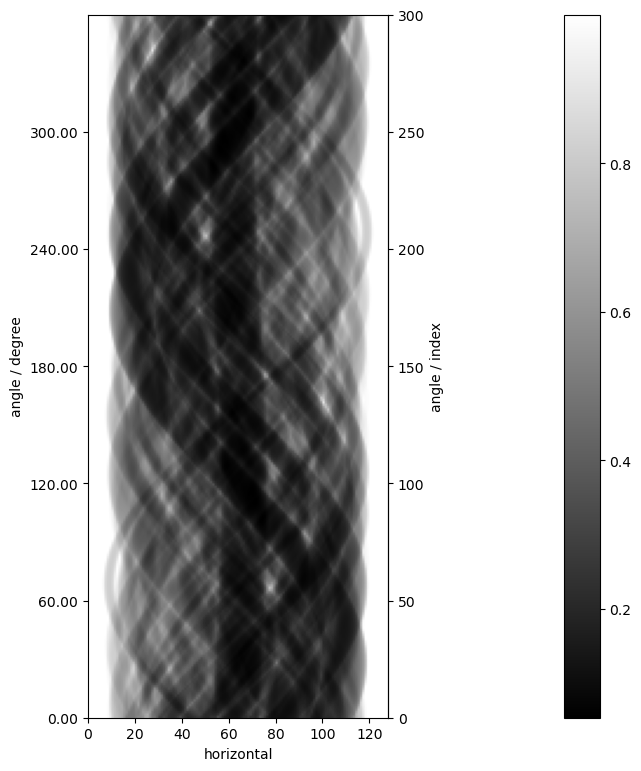

(300, 128)


10040.576171875

In [4]:
sampler=Sampling(5)
data=dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
data.reorder('astra')
data2d=data.get_slice(vertical='centre')
show2D(data2d)
print(data2d.array.shape)
ag2D = data2d.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()
A = ProjectionOperator(ig2D, ag2D, device = "cpu")
n_subsets = 5
partitioned_data=data2d.partition(n_subsets, 'sequential')
A_partitioned = ProjectionOperator(ig2D, partitioned_data.geometry, device = "cpu")
f_subsets = []
for i in range(n_subsets):
    fi=LeastSquares(A_partitioned.operators[i], partitioned_data[i])
    f_subsets.append(fi)
f=LeastSquares(A, data2d)
initial=ig2D.allocate(0)

f(initial)

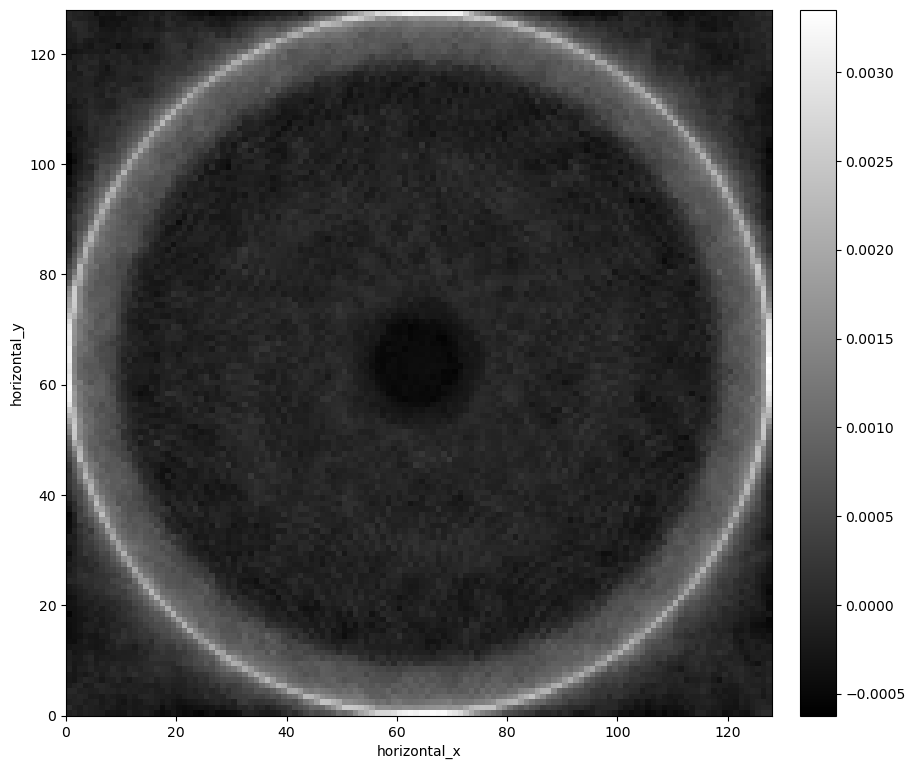

In [5]:

rate = f.L

alg = GD(initial=initial, 
                        objective_function=f, 
                        rate=rate, atol=1e-9, rtol=1e-6, alpha=1e8)
alg.max_iteration = 200
alg.run(verbose=0)
show2D(alg.x)


[[-2136.9854 -2193.7996 -2177.0923 ... -2218.6519 -2209.6702 -2165.4062]
 [-2174.6265 -2186.563  -2180.49   ... -2268.1125 -2272.5872 -2196.914 ]
 [-2195.8914 -2239.064  -2254.0588 ... -2321.0588 -2321.0884 -2238.976 ]
 ...
 [-2232.9392 -2328.7925 -2324.0532 ... -2259.893  -2266.5918 -2242.2432]
 [-2198.6492 -2250.8003 -2245.8142 ... -2223.0408 -2212.961  -2191.3584]
 [-2145.8118 -2187.3499 -2210.8174 ... -2227.1455 -2221.3628 -2197.026 ]]
[[-2009.9673 -2074.4333 -2040.2803 ... -2281.1575 -2326.6738 -2175.6055]
 [-2034.9128 -2003.8182 -2004.5751 ... -2414.5208 -2470.2686 -2209.407 ]
 [-2042.4043 -2027.2863 -2011.8196 ... -2355.7268 -2403.5593 -2261.3242]
 ...
 [-2197.8657 -2376.5276 -2341.305  ... -1952.7671 -2023.7621 -2152.18  ]
 [-2137.7268 -2415.3777 -2323.2915 ... -1960.5093 -2012.7101 -2112.3218]
 [-2069.4575 -2195.8684 -2188.2014 ... -1987.3394 -2092.3638 -2126.0789]]


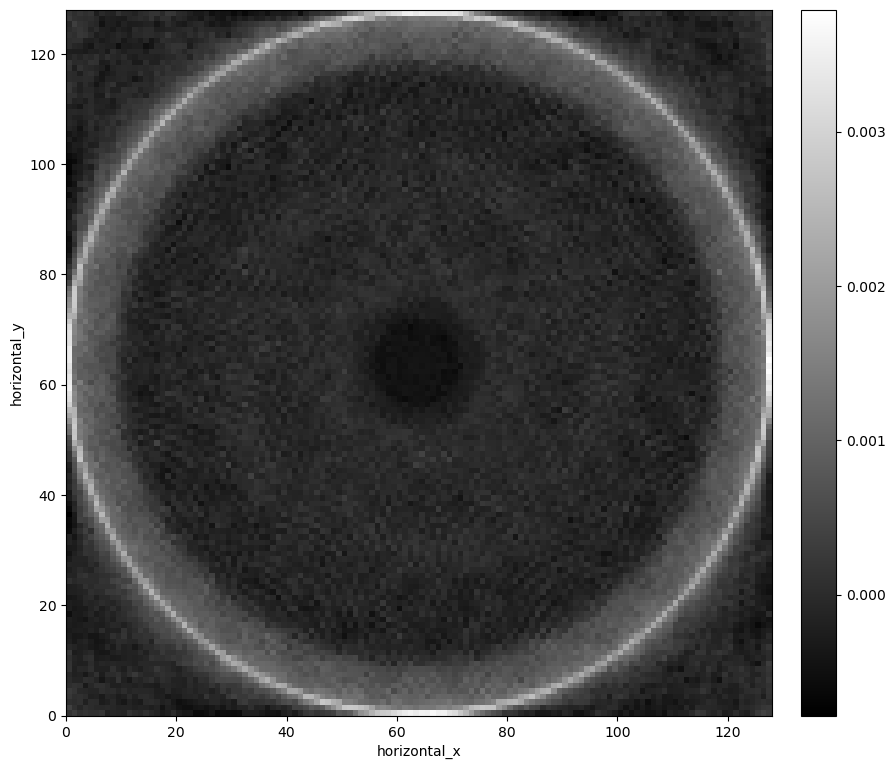

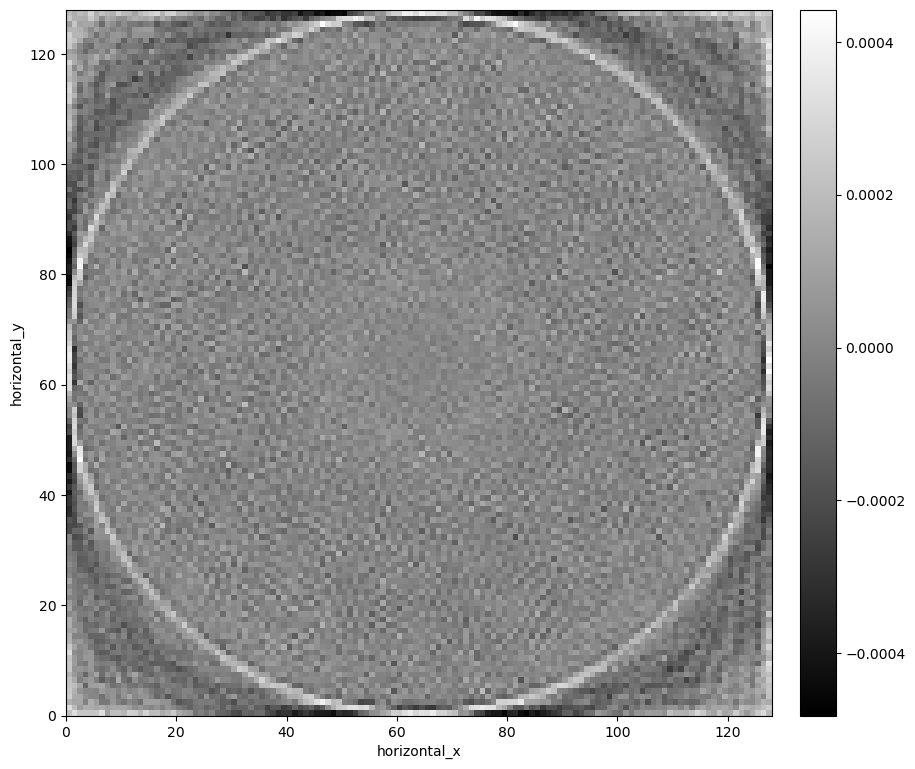

In [6]:
initial=ig2D.allocate(0)
objective=SGFunction(f_subsets, sampler)
print(objective.full_gradient(initial).array)
print(objective.gradient(initial).array)
alg_stochastic = GD(initial=initial, 
                        objective_function=objective, update_objective_interval=10, 
                        step_size=1e-7, max_iteration =5000)
alg_stochastic.run( 200, verbose=0)
show2D(alg_stochastic.x)
show2D(alg_stochastic.x-alg.x)
#self.assertNumpyArrayAlmostEqual(alg_stochastic.x.as_array(), alg.x.as_array(),3)

# Data information

We use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

    https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `path` variable below.

In [7]:
path = '../../data/walnut/valnut'

In [8]:
reader = ZEISSDataReader()
filename = "../data/valnut_tomo-A.txrm"
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1601,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

We need to define the following:

- The operator $K=(K_1,\dots,K_n)$.
- The functions $F=(F_1,\dots,F_N)$ and $G$.
- The maximum number of iterations



In [9]:
# Define number of subsets
n_subsets = 80

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag2D.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(data)
    
    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig2D, ageom_subset)
    A_subsets.append(Ai)
    # Define F_i and put into list
    fi = LeastSquares(Ai, b=data_subset, c=0.5)
    f_subsets.append(fi)


In [10]:


class Sampling():
    def __init__(self, num_subsets, prob=None, seed=99):
        self.num_subsets=num_subsets
        np.random.seed(seed)

        if prob==None:
            self.prob = [1/self.num_subsets] * self.num_subsets
        else:
            self.prob=prob
    def next(self):
        return int(np.random.choice(self.num_subsets, 1, p=self.prob))
sampler=Sampling(n_subsets)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          6.90194e+03
       10       1000         0.036          2.62801e+02
       20       1000         0.037          1.46173e+02
       30       1000         0.037          9.78599e+01
       40       1000         0.037          7.15617e+01
       50       1000         0.035          5.58607e+01
       60       1000         0.034          4.59333e+01
       70       1000         0.032          3.93646e+01
       80       1000         0.030          3.48492e+01
       90       1000         0.029          3.16425e+01
      100       1000         0.028          2.93004e+01
      110       1000         0.028          2.75479e+01
      120       1000         0.027          2.62086e+01
      130       1000         0.026          2.51659e+01
      140       1000         0.025          2.43408e+01
      150       1000         0.025          2.36

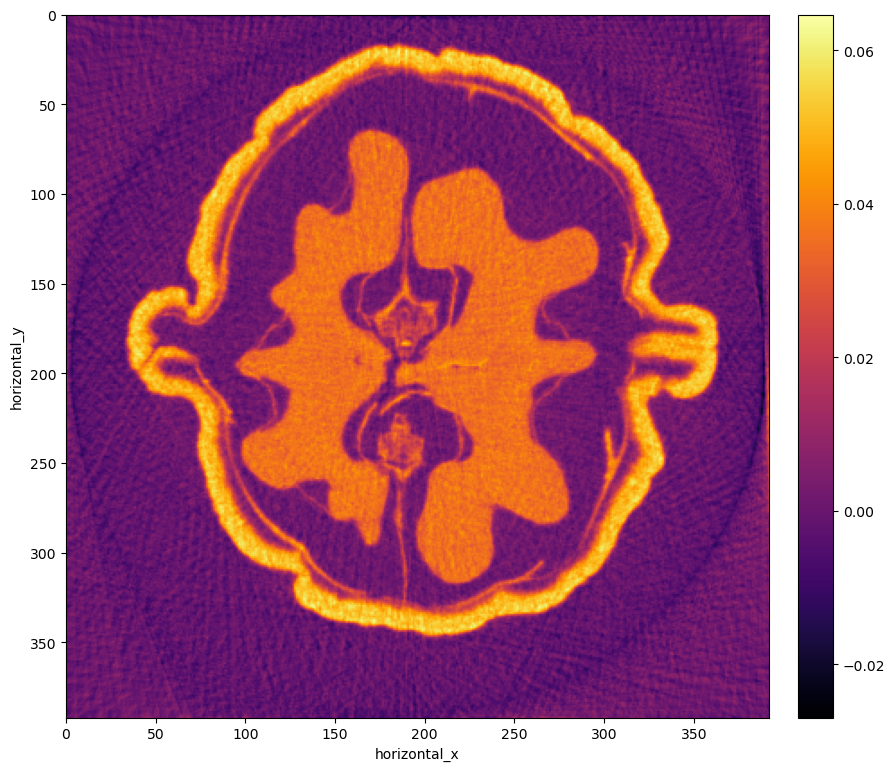

In [11]:
full_objective=(1/2)*LeastSquares(A, b=data)
myGD_LS = GD(initial=ig2D.allocate(0), 
             objective_function=full_objective, 
             step_size=0.001, 
             max_iteration=1000, 
             update_objective_interval=10)
myGD_LS.run(10000, verbose=1)

show2D(myGD_LS.solution, cmap="inferno", origin="upper")

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0      80000         0.000          6.90194e+03


      800      80000         0.006          2.03939e+01
     1600      80000         0.006          1.99742e+01
     2400      80000         0.006          1.96463e+01
     3200      80000         0.006          1.95604e+01
     4000      80000         0.006          1.95506e+01
     4800      80000         0.006          2.25014e+01
     5600      80000         0.006          1.96606e+01
     6400      80000         0.006          2.01121e+01
     7200      80000         0.006          2.29558e+01
     8000      80000         0.006          1.95791e+01
     8800      80000         0.006          1.97531e+01
     9600      80000         0.006          1.93521e+01
    10400      80000         0.006          1.93763e+01
    11200      80000         0.006          1.92071e+01
    12000      80000         0.006          1.97285e+01
    12800      80000         0.006          1.97841e+01
    13600      80000         0.006          1.92466e+01
    14400      80000         0.006          1.94

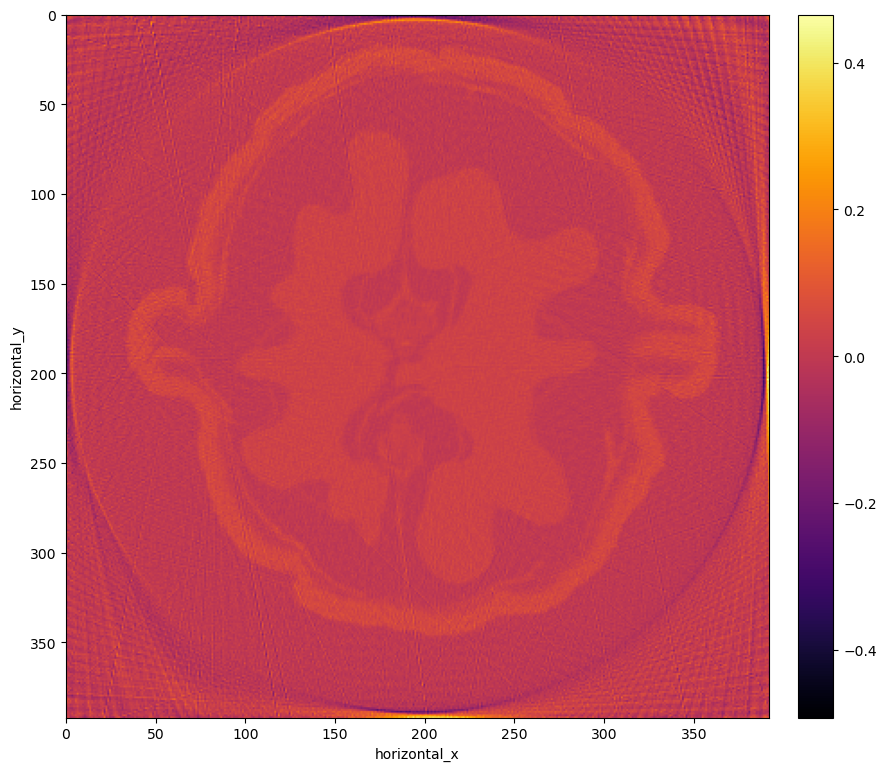

In [12]:
stochastic_objective=SGFunction(f_subsets,sampler) # TODO: Do we want it to take a block function or sum function or a list of functions?? 
#stochastic_objective=SGFunction(SumFunction(*f_subsets),sampler)
mySGD_LS_SG = GD(initial=ig2D.allocate(0), 
             objective_function=stochastic_objective, 
             step_size=0.001, 
             max_iteration=1000*n_subsets, 
             update_objective_interval=10*n_subsets)
mySGD_LS_SG.run(10000*n_subsets, verbose=1)

show2D(mySGD_LS_SG.solution, cmap="inferno", origin="upper")

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          6.90194e+03


       10       1000         0.055          1.53374e+02
       20       1000         0.043          7.64464e+01
       30       1000         0.039          4.90229e+01
       40       1000         0.037          3.68669e+01
       50       1000         0.035          3.06804e+01
       60       1000         0.035          2.71939e+01
       70       1000         0.034          2.50708e+01
       80       1000         0.034          2.36975e+01
       90       1000         0.033          2.27653e+01
      100       1000         0.033          2.21071e+01
      110       1000         0.033          2.16268e+01
      120       1000         0.033          2.12664e+01
      130       1000         0.032          2.09893e+01
      140       1000         0.032          2.07716e+01
      150       1000         0.032          2.05973e+01
      160       1000         0.032          2.04555e+01
      170       1000         0.032          2.03382e+01
      180       1000         0.032          2.02

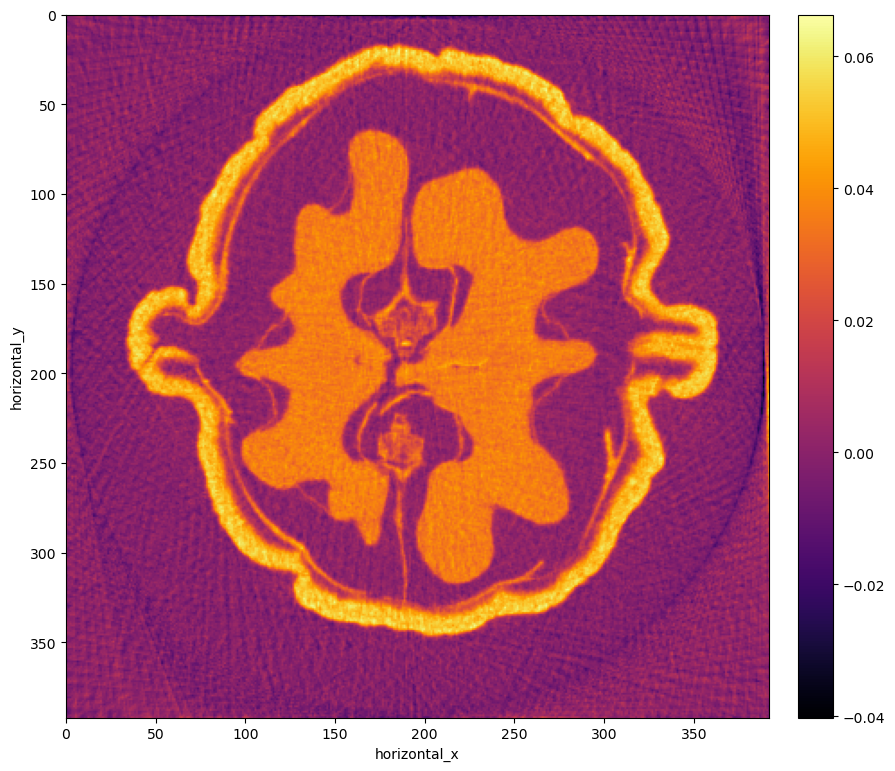

In [13]:
full_objective=(1/2)*LeastSquares(A, b=data)
myGD_LS_BT = GD(initial=ig2D.allocate(0), 
             objective_function=full_objective, 
             max_iteration=1000, 
             update_objective_interval=10)
myGD_LS_BT.run(10000, verbose=1)

show2D(myGD_LS_BT.solution, cmap="inferno", origin="upper")

In [14]:
#stochastic_objective=SGFunction(f_subsets,sampler) # TODO: Do we want it to take a block function or a list of functions?? 
#mySGD_LS_BT_SG = GD(initial=ig2D.allocate(0), 
#             objective_function=stochastic_objective, 
#             max_iteration=1000, 
#             update_objective_interval=100)
#mySGD_LS_BT_SG.run(1000, verbose=1)
#
#show2D(mySGD_LS_BT_SG.solution, cmap="inferno", origin="upper")

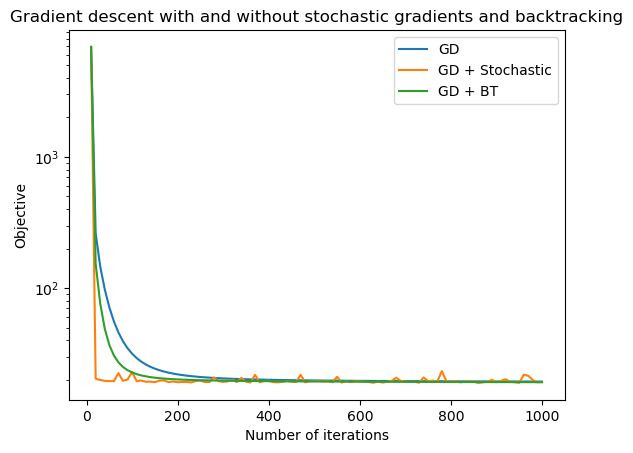

In [15]:
plt.figure()
plt.semilogy(range(10, 1001, 10), myGD_LS.objective[1:101], label='GD' )
plt.semilogy(range(10, 1001, 10), mySGD_LS_SG.objective[1:101], label='GD + Stochastic')
plt.semilogy(range(10, 1001, 10), myGD_LS_BT.objective[1:101], label='GD + BT')
#plt.semilogy(range(0, 1000, 100), mySGD_LS_BT_SG.objective, label=SGD + Stochastic +BT')
plt.xlabel('Number of iterations')
plt.ylabel('Objective')
plt.title('Gradient descent with and without stochastic gradients and backtracking')
plt.legend()
plt.show() 

0.0019122747775957157
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          6.90194e+03
        1        200         0.045          6.52337e+02
        2        200         0.036          4.85588e+02
        3        200         0.033          3.81630e+02
        4        200         0.032          3.13447e+02


        5        200         0.032          2.66273e+02
        6        200         0.032          2.31947e+02
        7        200         0.032          2.05904e+02
        8        200         0.032          1.85398e+02
        9        200         0.032          1.68635e+02
       10        200         0.032          1.54570e+02
       11        200         0.032          1.42549e+02
       12        200         0.032          1.32106e+02
       13        200         0.032          1.22941e+02
       14        200         0.032          1.14844e+02
       15        200         0.032          1.07653e+02
       16        200         0.032          1.01244e+02
       17        200         0.032          9.55128e+01
       18        200         0.032          9.03704e+01
       19        200         0.032          8.57418e+01
       20        200         0.032          8.15637e+01
       21        200         0.031          7.77852e+01
       22        200         0.031          7.43

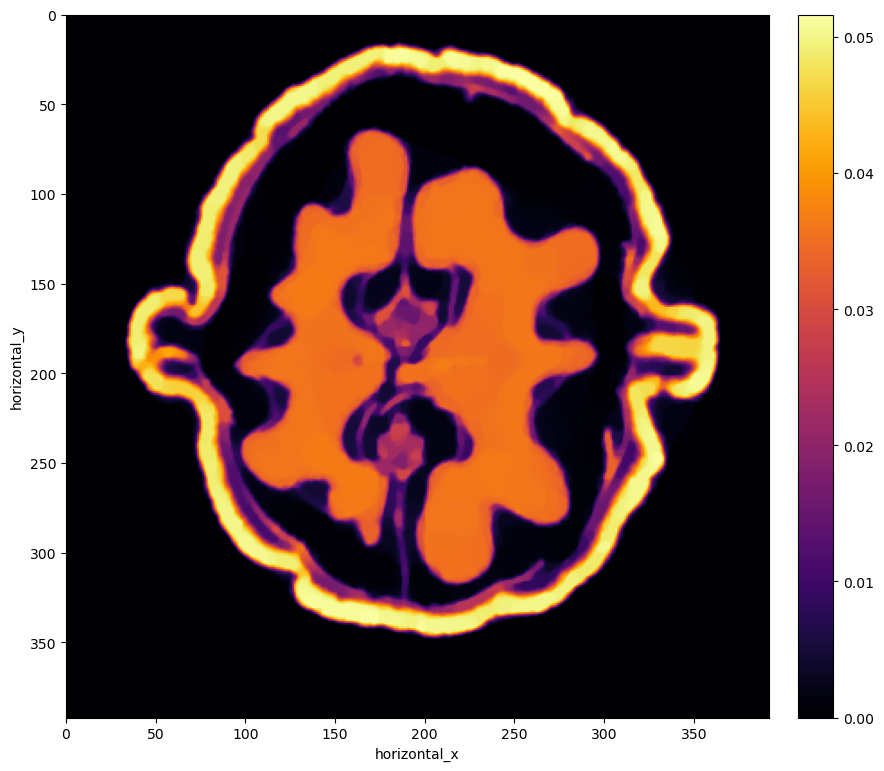

In [16]:
num_epochs=200
alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0)
F_ISTA = LeastSquares(A, b = data, c = 0.5)
step_size_ista = 1./F_ISTA.L
print(step_size_ista)
ista = ISTA(initial = initial, f=F_ISTA, step_size = step_size_ista, g=G, update_objective_interval = 1, 
            max_iteration = num_epochs)
ista.run(verbose=1)
optimal = ista.solution
show2D(ista.solution, cmap="inferno", origin="upper")

0.0019122747775957157
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          6.90194e+03
        1        200         0.040          6.52337e+02
        2        200         0.040          4.85588e+02
        3        200         0.041          3.56509e+02
        4        200         0.040          2.66606e+02
        5        200         0.038          2.06641e+02
        6        200         0.036          1.65633e+02
        7        200         0.035          1.34646e+02
        8        200         0.034          1.09700e+02
        9        200         0.034          8.97772e+01


       10        200         0.034          7.43820e+01
       11        200         0.034          6.28664e+01
       12        200         0.034          5.44688e+01
       13        200         0.034          4.84020e+01
       14        200         0.033          4.40015e+01
       15        200         0.033          4.07654e+01
       16        200         0.033          3.83473e+01
       17        200         0.032          3.65260e+01
       18        200         0.032          3.51529e+01
       19        200         0.032          3.41085e+01
       20        200         0.032          3.33133e+01
       21        200         0.032          3.27103e+01
       22        200         0.033          3.22518e+01
       23        200         0.033          3.19017e+01
       24        200         0.033          3.16324e+01
       25        200         0.032          3.14218e+01
       26        200         0.032          3.12517e+01
       27        200         0.032          3.11

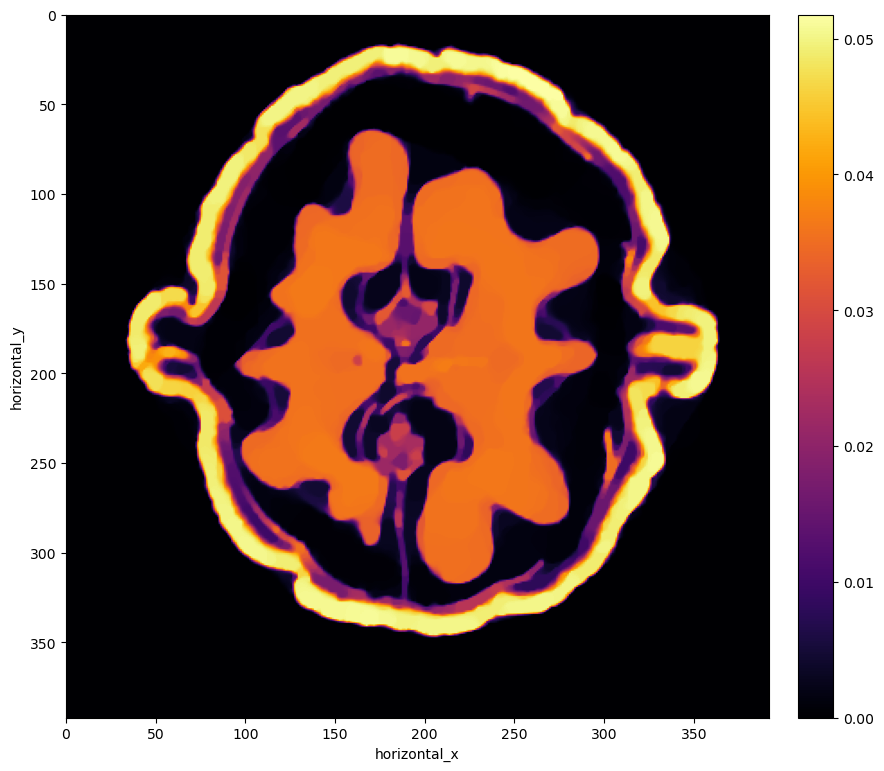

In [17]:

alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0)
F_FISTA = LeastSquares(A, b = data, c = 0.5)
step_size_fista = 1./F_FISTA.L
print(step_size_fista)
fista = FISTA(initial = initial, f=F_FISTA, step_size = step_size_fista, g=G, update_objective_interval = 1, 
            max_iteration = num_epochs)
fista.run(verbose=1)
optimal = fista.solution
show2D(fista.solution, cmap="inferno", origin="upper")

0.0016367170713029425
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0      16000         0.000          6.90194e+03
       80      16000         0.018          4.04431e+01
      160      16000         0.018          3.40766e+01
      240      16000         0.019          3.24921e+01
      320      16000         0.019          3.26579e+01
      400      16000         0.019          3.18810e+01
      480      16000         0.019          3.18124e+01
      560      16000         0.019          3.14379e+01
      640      16000         0.019          3.17339e+01
      720      16000         0.019          3.37316e+01
      800      16000         0.019          3.31155e+01
      880      16000         0.019          3.18441e+01
      960      16000         0.019          3.15938e+01
     1040      16000         0.019          3.19667e+01
     1120      16000         0.019          3.31054e+01
     1200      16000      

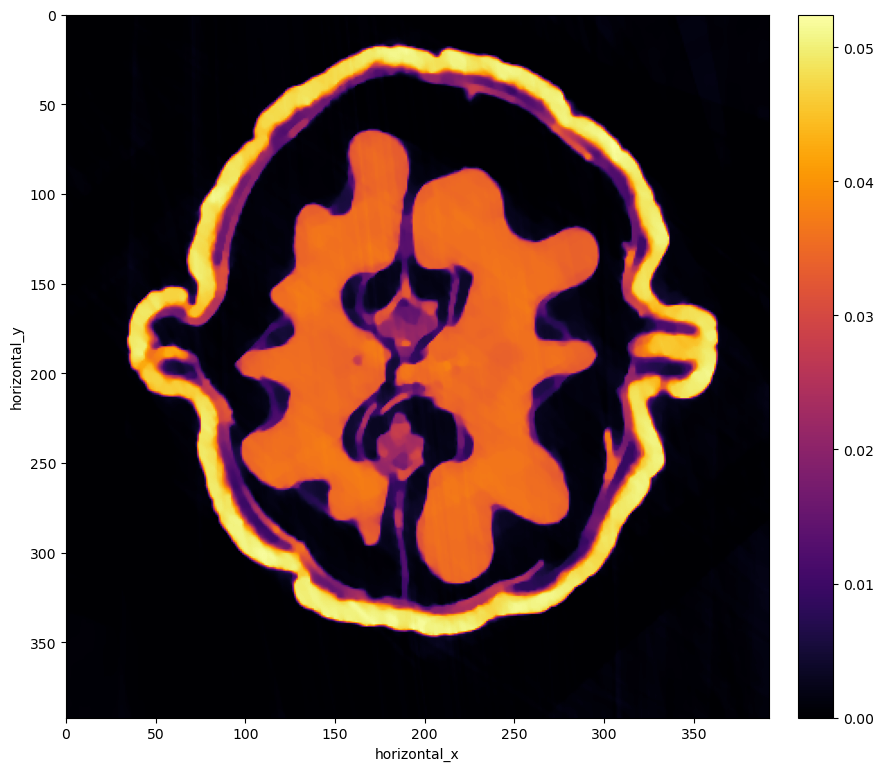

In [18]:
alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0)
F_ISTA_SG = SGFunction(f_subsets,sampler)
step_size_ista_SG= 1./F_ISTA_SG.L #FIXME: how to set this?? 
print(step_size_ista_SG)
ista_SG = ISTA(initial = initial, f=F_ISTA_SG, step_size = step_size_ista_SG, g=G, update_objective_interval = n_subsets, 
            max_iteration = num_epochs*n_subsets)
ista_SG.run(verbose=1)
optimalSG = ista_SG.solution
show2D(ista_SG.solution, cmap="inferno", origin="upper")

In [19]:
print(step_size_ista)

0.0019122747775957157


1.0229481695643391e-05
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0      16000         0.000          6.90194e+03
       80      16000         0.019          3.01869e+02
      160      16000         0.019          8.45600e+01
      240      16000         0.019          4.44381e+01
      320      16000         0.019          3.41261e+01
      400      16000         0.020          3.26417e+01
      480      16000         0.020          3.18385e+01
      560      16000         0.019          3.14078e+01
      640      16000         0.020          3.11193e+01
      720      16000         0.020          3.11149e+01
      800      16000         0.020          3.09769e+01
      880      16000         0.020          3.10011e+01
      960      16000         0.020          3.11207e+01
     1040      16000         0.020          3.12595e+01
     1120      16000         0.020          3.10388e+01
     1200      16000     

     2080      16000         0.020          3.19944e+01
     2160      16000         0.020          3.22257e+01
     2240      16000         0.020          3.15871e+01
     2320      16000         0.020          3.12598e+01
     2400      16000         0.020          3.13683e+01
     2480      16000         0.020          3.17192e+01
     2560      16000         0.020          3.30597e+01
     2640      16000         0.020          3.21140e+01
     2720      16000         0.020          3.20846e+01
     2800      16000         0.020          3.27350e+01
     2880      16000         0.020          3.16503e+01
     2960      16000         0.020          3.19012e+01
     3040      16000         0.020          3.23858e+01
     3120      16000         0.020          3.16317e+01
     3200      16000         0.020          3.15608e+01
     3280      16000         0.020          3.21914e+01
     3360      16000         0.020          3.25788e+01
     3440      16000         0.020          3.19

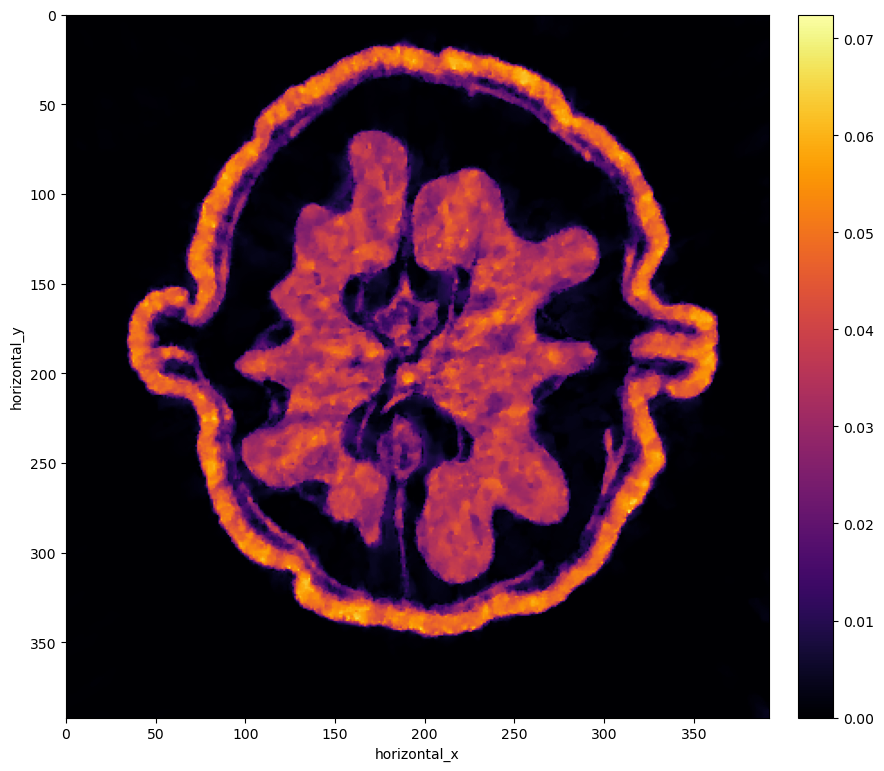

In [20]:

alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0) 
F_FISTA_SG = SGFunction(f_subsets,sampler)
step_size_fista = 1./(2*n_subsets*F_FISTA_SG.L) #FIXME: how to set this?? #TODO: backtracking??  
print(step_size_fista)
fista_SG = FISTA(initial = initial, f=F_FISTA_SG, step_size = step_size_fista, g=G, update_objective_interval = n_subsets, 
            max_iteration = num_epochs*n_subsets)
fista_SG.run(verbose=1)
optimal = fista_SG.solution
show2D(fista_SG.solution, cmap="inferno", origin="upper")

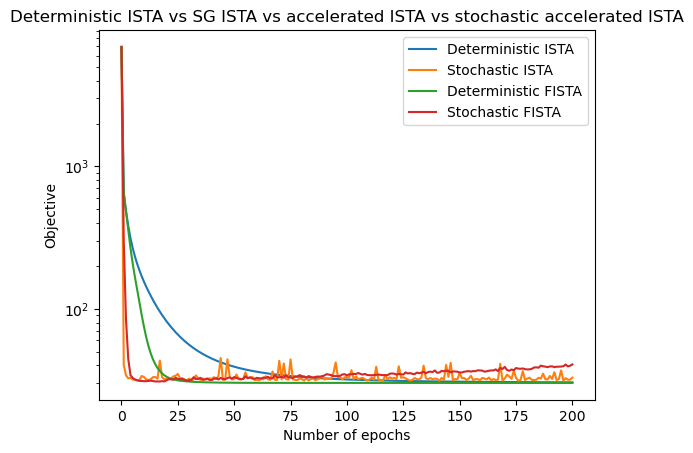

In [21]:
plt.figure()
plt.semilogy(range(0, num_epochs+1), ista.objective, label='Deterministic ISTA' )
plt.semilogy(range(0, num_epochs+1), ista_SG.objective, label='Stochastic ISTA')
plt.semilogy(range(0, num_epochs+1), fista.objective, label='Deterministic FISTA')
plt.semilogy(range(0, num_epochs+1), fista_SG.objective, label='Stochastic FISTA')
plt.xlabel('Number of epochs')
plt.ylabel('Objective')
plt.title('Deterministic ISTA vs SG ISTA vs accelerated ISTA vs stochastic accelerated ISTA')
plt.legend()
plt.show()